# loading the datasets and inspecting their contents.

In [2]:
import pandas as pd

# Load the datasets
tweets_df = pd.read_csv('stock_tweets.csv')
stock_data_df = pd.read_csv('stock_yfinance_data.csv')

# Display the first few rows of each dataset
tweets_df_head = tweets_df.head()
stock_data_df_head = stock_data_df.head()

tweets_df_head, stock_data_df_head

(                        Date  \
 0  2022-09-29 23:41:16+00:00   
 1  2022-09-29 23:24:43+00:00   
 2  2022-09-29 23:18:08+00:00   
 3  2022-09-29 22:40:07+00:00   
 4  2022-09-29 22:27:05+00:00   
 
                                                Tweet Stock Name Company Name  
 0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
 1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
 2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
 3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
 4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  ,
          Date        Open        High         Low       Close   Adj Close  \
 0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
 1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
 2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
 3  202

# converting the date columns and inspecting for any missing values.

In [3]:
# Convert the date columns to datetime format
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'])

# Check for missing values
tweets_missing = tweets_df.isnull().sum()
stock_data_missing = stock_data_df.isnull().sum()

tweets_missing, stock_data_missing

(Date            0
 Tweet           0
 Stock Name      0
 Company Name    0
 dtype: int64,
 Date          0
 Open          0
 High          0
 Low           0
 Close         0
 Adj Close     0
 Volume        0
 Stock Name    0
 dtype: int64)

# Sentiment Analysis using NLP Techniques

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon if not already done
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each tweet
tweets_df['Sentiment'] = tweets_df['Tweet'].apply(lambda tweet: vader.polarity_scores(tweet)['compound'])

# Aggregate sentiment scores by date and stock name
daily_sentiment = tweets_df.groupby(['Date', 'Stock Name']).agg({'Sentiment': 'mean'}).reset_index()

# Display the aggregated sentiment scores
daily_sentiment.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maxpa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Date,Stock Name,Sentiment
0,2021-09-30 00:06:02+00:00,GOOG,0.4404
1,2021-09-30 00:13:26+00:00,TSM,0.0000
2,2021-09-30 00:14:49+00:00,TSM,0.8862
3,2021-09-30 00:16:45+00:00,TSM,0.5815
4,2021-09-30 00:24:50+00:00,TSM,-0.2726


# Merge Sentiment Data with Stock Data and Calculate Technical Indicators

In [6]:
# Merge the sentiment data with the stock price data
stock_data_df['Date'] = stock_data_df['Date'].dt.tz_localize('UTC')  # Ensure timezone awareness
merged_df = pd.merge(stock_data_df, daily_sentiment, on=['Date', 'Stock Name'], how='left')

# Fill missing sentiment values with zero (neutral sentiment)
merged_df['Sentiment'].fillna(0, inplace=True)

# Calculate simple moving averages (SMA)
merged_df['SMA_5'] = merged_df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=5).mean())
merged_df['SMA_10'] = merged_df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=10).mean())

# Calculate Relative Strength Index (RSI)
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_df['RSI_14'] = merged_df.groupby('Stock Name')['Close'].transform(calculate_rsi)

# Calculate MACD (Moving Average Convergence Divergence)
ema_12 = merged_df.groupby('Stock Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = merged_df.groupby('Stock Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
merged_df['MACD'] = ema_12 - ema_26

# Display the first few rows of the merged DataFrame with technical indicators
print(merged_df.head())

C:\Users\maxpa\AppData\Local\Temp\ipykernel_5956\33662727.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiment'].fillna(0, inplace=True)


                       Date        Open        High         Low       Close  \
0 2021-09-30 00:00:00+00:00  260.333344  263.043335  258.333344  258.493347   
1 2021-10-01 00:00:00+00:00  259.466675  260.260010  254.529999  258.406677   
2 2021-10-04 00:00:00+00:00  265.500000  268.989990  258.706665  260.510010   
3 2021-10-05 00:00:00+00:00  261.600006  265.769989  258.066681  260.196655   
4 2021-10-06 00:00:00+00:00  258.733337  262.220001  257.739990  260.916656   

    Adj Close    Volume Stock Name  Sentiment       SMA_5  SMA_10  RSI_14  \
0  258.493347  53868000       TSLA        0.0         NaN     NaN     NaN   
1  258.406677  51094200       TSLA        0.0         NaN     NaN     NaN   
2  260.510010  91449900       TSLA        0.0         NaN     NaN     NaN   
3  260.196655  55297800       TSLA        0.0         NaN     NaN     NaN   
4  260.916656  43898400       TSLA        0.0  259.704669     NaN     NaN   

       MACD  
0  0.000000  
1 -0.006914  
2  0.155535  
3  0.2

# Create Lagged Features and Define Target Variable

In [7]:
# Create lagged features for sentiment and technical indicators
lags = [1, 2, 3]  # Number of days to lag
for lag in lags:
    merged_df[f'Sentiment_Lag_{lag}'] = merged_df.groupby('Stock Name')['Sentiment'].shift(lag)
    merged_df[f'SMA_5_Lag_{lag}'] = merged_df.groupby('Stock Name')['SMA_5'].shift(lag)
    merged_df[f'SMA_10_Lag_{lag}'] = merged_df.groupby('Stock Name')['SMA_10'].shift(lag)
    merged_df[f'RSI_14_Lag_{lag}'] = merged_df.groupby('Stock Name')['RSI_14'].shift(lag)
    merged_df[f'MACD_Lag_{lag}'] = merged_df.groupby('Stock Name')['MACD'].shift(lag)

# Define the target variable: Predict the next day's closing price change
merged_df['Target'] = merged_df.groupby('Stock Name')['Close'].shift(-1) - merged_df['Close']

# Create a binary target variable for classification (1 if price goes up, 0 otherwise)
merged_df['Target_Classification'] = (merged_df['Target'] > 0).astype(int)

# Drop rows with NaN values after creating lagged features
model_data = merged_df.dropna()

# Display the first few rows of the dataset prepared for modeling
print(model_data.head())

                        Date        Open        High         Low       Close  \
16 2021-10-22 00:00:00+00:00  298.500000  303.333344  296.986664  303.226654   
17 2021-10-25 00:00:00+00:00  316.843323  348.339996  314.733337  341.619995   
18 2021-10-26 00:00:00+00:00  341.563324  364.980011  333.813324  339.476654   
19 2021-10-27 00:00:00+00:00  346.553345  356.959991  343.593323  345.953339   
20 2021-10-28 00:00:00+00:00  356.103333  360.333344  351.399994  359.013336   

     Adj Close     Volume Stock Name  Sentiment       SMA_5  ...  \
16  303.226654   68642400       TSLA        0.0  293.590668  ...   
17  341.619995  188556300       TSLA        0.0  303.907330  ...   
18  339.476654  187245000       TSLA        0.0  314.184662  ...   
19  345.953339  115579500       TSLA        0.0  325.655328  ...   
20  359.013336   81639600       TSLA        0.0  337.857996  ...   

    SMA_10_Lag_2  RSI_14_Lag_2  MACD_Lag_2  Sentiment_Lag_3  SMA_5_Lag_3  \
16    274.979004     87.433550    

# Train a Classification Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Features and target
features = [
    'Sentiment', 'SMA_5', 'SMA_10', 'RSI_14', 'MACD',
    'Sentiment_Lag_1', 'SMA_5_Lag_1', 'SMA_10_Lag_1', 'RSI_14_Lag_1', 'MACD_Lag_1',
    'Sentiment_Lag_2', 'SMA_5_Lag_2', 'SMA_10_Lag_2', 'RSI_14_Lag_2', 'MACD_Lag_2',
    'Sentiment_Lag_3', 'SMA_5_Lag_3', 'SMA_10_Lag_3', 'RSI_14_Lag_3', 'MACD_Lag_3'
]
target = 'Target_Classification'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    model_data[features], model_data[target], test_size=0.2, random_state=42, stratify=model_data[target]
)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(report)

Model Evaluation:
Accuracy: 0.51
F1 Score: 0.46
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       619
           1       0.49      0.44      0.46       556

    accuracy                           0.51      1175
   macro avg       0.51      0.51      0.51      1175
weighted avg       0.51      0.51      0.51      1175



# Feature Importance Analysis and Visualization

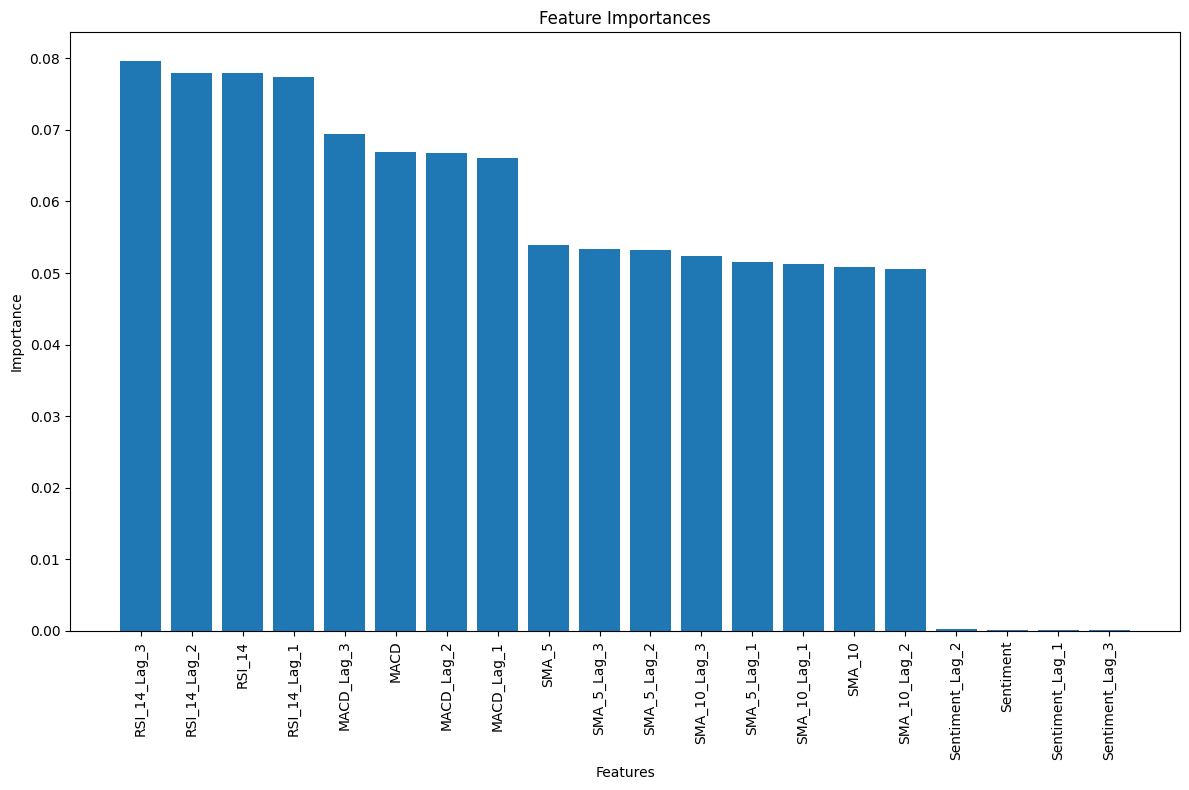

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained model
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Create a bar plot of feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2,
                           scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score from Grid Search:", best_score)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best F1 Score from Grid Search: 0.47138880871094174


# Visualize Model Performance

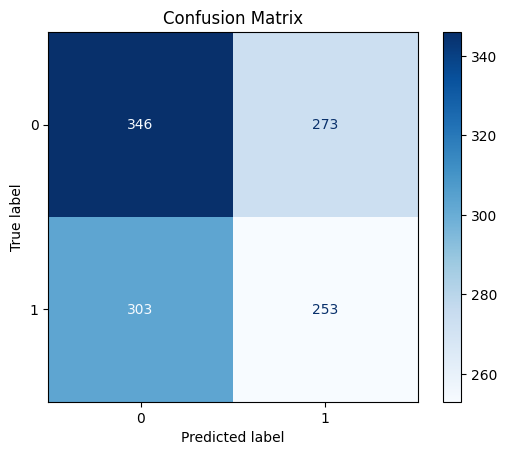

Best Model Accuracy: 0.5097872340425532
Best Model F1 Score: 0.4676524953789279


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Create and plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate and display accuracy and F1 score of the best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

print("Best Model Accuracy:", best_accuracy)
print("Best Model F1 Score:", best_f1)

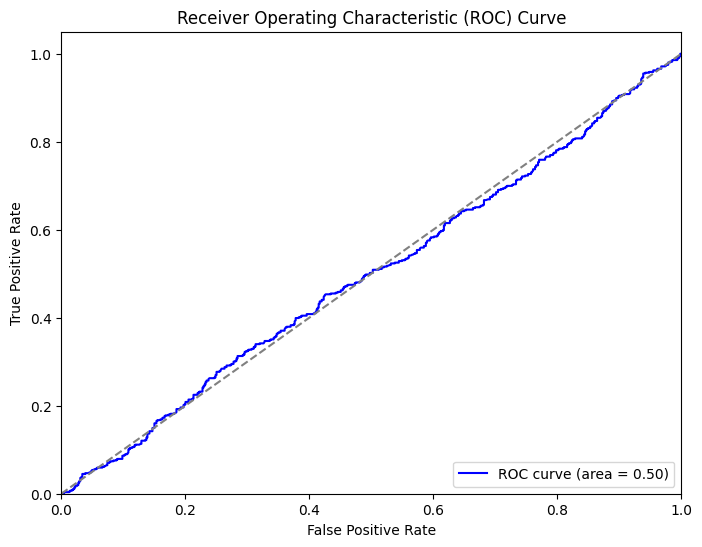

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Calculate probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

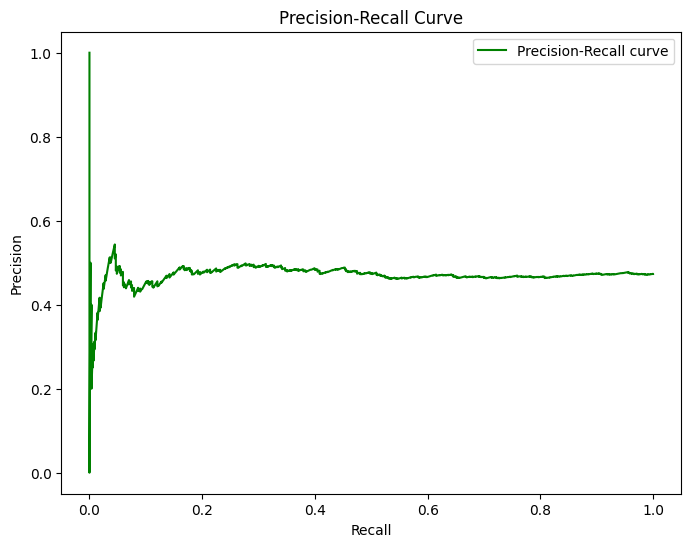

In [14]:
# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [17]:
def generate_recommendations(X_test, model, model_data):
    """
    Generate buy/sell recommendations based on model predictions.

    Args:
    X_test (pd.DataFrame): DataFrame containing the features for prediction.
    model (sklearn model): Trained model to make predictions.
    model_data (pd.DataFrame): Original DataFrame with stock and date information.

    Returns:
    pd.DataFrame: DataFrame containing recommendations.
    """
    # Make predictions
    predictions = model.predict(X_test)

    # Align indices with the original data
    test_indices = X_test.index

    # Create recommendations
    recommendations = ["Buy" if pred == 1 else "Sell" for pred in predictions]

    # Return a DataFrame with the results
    return pd.DataFrame({
        'Date': model_data.loc[test_indices, 'Date'].values,
        'Stock Name': model_data.loc[test_indices, 'Stock Name'].values,
        'Recommendation': recommendations
    })

# Generate recommendations for the test set
recommendations = generate_recommendations(X_test, best_model, model_data)

# Display the recommendations
print(recommendations.head())

        Date Stock Name Recommendation
0 2022-04-06       GOOG           Sell
1 2022-08-03         BA           Sell
2 2022-05-24        NOC           Sell
3 2022-08-01        CRM           Sell
4 2021-11-18       COST            Buy


In [20]:
def backtest_strategy(recommendations, test_data):
    """
    Simulate a trading strategy based on model recommendations.

    Args:
    recommendations (pd.DataFrame): DataFrame containing recommendations.
    test_data (pd.DataFrame): DataFrame containing test stock data.

    Returns:
    float: Total return from the simulated strategy.
    """
    # Initialize portfolio value and position
    portfolio_value = 10000  # Starting portfolio value
    position = 0  # Current position: +1 for long, 0 for no position

    # Use only indices present in both recommendations and test_data
    valid_indices = recommendations.index.intersection(test_data.index)

    # Iterate over the recommendations using aligned indices
    for idx in valid_indices:
        recommendation = recommendations.loc[idx, 'Recommendation']
        current_price = test_data.loc[idx, 'Close']

        if recommendation == "Buy" and position == 0:
            # Buy stock
            shares_to_buy = portfolio_value // current_price
            portfolio_value -= shares_to_buy * current_price
            position += shares_to_buy
        elif recommendation == "Sell" and position > 0:
            # Sell stock
            portfolio_value += position * current_price
            position = 0

    # If we hold a position at the end, sell it
    if position > 0:
        portfolio_value += position * test_data['Close'].iloc[-1]

    return portfolio_value

# Align the test data to ensure correct index usage
test_data = model_data.loc[X_test.index]

# Run the backtest
final_portfolio_value = backtest_strategy(recommendations, test_data)
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $5796.33


C:\Users\maxpa\AppData\Local\Temp\ipykernel_5956\1228686934.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = recommendations.loc[common_indices][recommendations['Recommendation'] == 'Buy']
C:\Users\maxpa\AppData\Local\Temp\ipykernel_5956\1228686934.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = recommendations.loc[common_indices][recommendations['Recommendation'] == 'Sell']


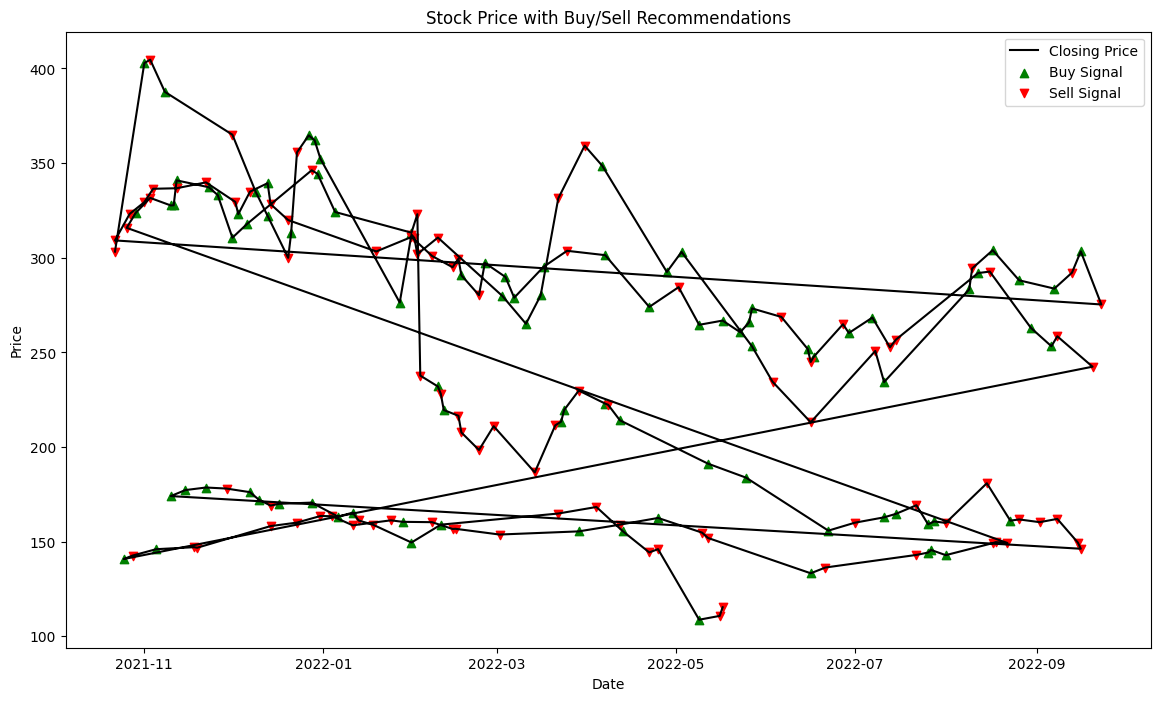

In [22]:
def plot_recommendations_and_value(test_data, recommendations):
    """
    Plot stock prices and recommendations over time.

    Args:
    test_data (pd.DataFrame): DataFrame containing test stock data.
    recommendations (pd.DataFrame): DataFrame containing recommendations.
    """
    plt.figure(figsize=(14, 8))

    # Use common indices to avoid KeyError
    common_indices = recommendations.index.intersection(test_data.index)

    # Plot closing prices
    plt.plot(test_data.loc[common_indices, 'Date'], test_data.loc[common_indices, 'Close'], label='Closing Price', color='black')

    # Plot recommendations
    buy_signals = recommendations.loc[common_indices][recommendations['Recommendation'] == 'Buy']
    sell_signals = recommendations.loc[common_indices][recommendations['Recommendation'] == 'Sell']
    plt.scatter(test_data.loc[buy_signals.index, 'Date'], test_data.loc[buy_signals.index, 'Close'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(test_data.loc[sell_signals.index, 'Date'], test_data.loc[sell_signals.index, 'Close'], color='red', label='Sell Signal', marker='v', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price with Buy/Sell Recommendations')
    plt.legend()
    plt.show()

# Ensure test_data aligns with recommendations
test_data = model_data.loc[X_test.index]

# Plot recommendations and strategy
plot_recommendations_and_value(test_data, recommendations)

# A. Use of Gradient Boosting Models

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Evaluate the model using cross-validation
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1')
print(f"XGBoost Cross-Validated F1 Score: {xgb_scores.mean():.2f}")

# Fit and evaluate the model
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"XGBoost F1 Score: {xgb_f1:.2f}")

XGBoost Cross-Validated F1 Score: 0.44
XGBoost Accuracy: 0.50
XGBoost F1 Score: 0.41


# B. Explore LightGBM

In [27]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.4 MB 1.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.4 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 11.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
from lightgbm import LGBMClassifier

# Initialize LightGBM Classifier
lgb_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Evaluate the model using cross-validation
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='f1')
print(f"LightGBM Cross-Validated F1 Score: {lgb_scores.mean():.2f}")

# Fit and evaluate the model
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_f1 = f1_score(y_test, y_pred_lgb)

print(f"LightGBM Accuracy: {lgb_accuracy:.2f}")
print(f"LightGBM F1 Score: {lgb_f1:.2f}")

[LightGBM] [Info] Number of positive: 1777, number of negative: 1983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472606 -> initscore=-0.109684
[LightGBM] [Info] Start training from score -0.109684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [30]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.7 MB 2.6 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.7 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 12.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 1.1/385.2 MB 35.0 MB/s eta 0:00:11
   ---------------------------------------- 2.5/385.2 MB 31.6 MB/s eta 0:00:13
   ---------------------------------------- 3.6/385.2 MB 28.6 MB/s eta 0:00:14
    --------------------------------------- 5.2/385.2 MB 30.2 MB/s eta 0:00:13
    --------------------------------------- 6.6/385.2 MB 30.3 MB/s eta 0:00:13
    --------------------------------------- 7.5/385.2 MB 31.9 MB/s eta 0:00:12
    --------------------------------------- 7.8/385.2 MB 24.9 MB/s eta 0:00:16
    --------------------------------------- 8.9/385.2 MB 24.9 MB/s eta 0:00:1

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from transformers import pipeline

# Initialize a sentiment analysis pipeline using a BERT model
sentiment_pipeline = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Analyze sentiment for each tweet
tweets_df['Advanced_Sentiment'] = tweets_df['Tweet'].apply(lambda tweet: sentiment_pipeline(tweet)[0]['label'])

# Convert sentiment labels to numerical scores
sentiment_mapping = {
    '1 star': -1,
    '2 stars': -0.5,
    '3 stars': 0,
    '4 stars': 0.5,
    '5 stars': 1
}
tweets_df['Advanced_Sentiment_Score'] = tweets_df['Advanced_Sentiment'].map(sentiment_mapping)

# Aggregate advanced sentiment scores by date and stock name
advanced_sentiment = tweets_df.groupby(['Date', 'Stock Name']).agg({'Advanced_Sentiment_Score': 'mean'}).reset_index()

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [32]:
# Calculate rolling averages of sentiment scores
advanced_sentiment['Sentiment_MA_5'] = advanced_sentiment.groupby('Stock Name')['Advanced_Sentiment_Score'].transform(lambda x: x.rolling(window=5).mean())
advanced_sentiment['Sentiment_EMA_5'] = advanced_sentiment.groupby('Stock Name')['Advanced_Sentiment_Score'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

# Retrain Models with Enhanced Features

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize XGBoost Classifier with optimized parameters
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model with the enhanced features
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print("XGBoost Model Evaluation:")
print(f"Accuracy: {xgb_accuracy:.2f}")
print(f"F1 Score: {xgb_f1:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Model Evaluation:
Accuracy: 0.50
F1 Score: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.61      0.56       619
           1       0.46      0.37      0.41       556

    accuracy                           0.50      1175
   macro avg       0.49      0.49      0.48      1175
weighted avg       0.49      0.50      0.49      1175



In [34]:
from lightgbm import LGBMClassifier

# Initialize LightGBM Classifier with optimized parameters
lgb_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train the model with the enhanced features
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
lgb_f1 = f1_score(y_test, y_pred_lgb)

print("LightGBM Model Evaluation:")
print(f"Accuracy: {lgb_accuracy:.2f}")
print(f"F1 Score: {lgb_f1:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 2222, number of negative: 2478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 4700, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472766 -> initscore=-0.109044
[LightGBM] [Info] Start training from score -0.109044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [36]:
def refined_backtest_strategy(recommendations, test_data, model_confidence, stop_loss_pct=0.05, take_profit_pct=0.05):
    """
    Simulate an enhanced trading strategy based on model recommendations with trailing stop-loss and take-profit.

    Args:
    recommendations (pd.DataFrame): DataFrame containing recommendations.
    test_data (pd.DataFrame): DataFrame containing test stock data.
    model_confidence (pd.Series): Model confidence scores for buy recommendations.
    stop_loss_pct (float): Percentage loss at which to stop and sell.
    take_profit_pct (float): Percentage gain at which to take profit.

    Returns:
    float: Total return from the enhanced simulated strategy.
    """
    portfolio_value = 10000  # Starting portfolio value
    position = 0
    stop_loss_price = None
    take_profit_price = None

    # Ensure recommendations and test_data indices align
    common_indices = recommendations.index.intersection(test_data.index)

    for idx in common_indices:
        recommendation = recommendations.loc[idx, 'Recommendation']
        current_price = test_data.loc[idx, 'Close']

        if recommendation == "Buy" and position == 0:
            # Determine number of shares based on model confidence
            confidence = model_confidence.loc[idx]
            risk_adjusted_position = int(portfolio_value * confidence // current_price)
            portfolio_value -= risk_adjusted_position * current_price
            position += risk_adjusted_position
            stop_loss_price = current_price * (1 - stop_loss_pct)
            take_profit_price = current_price * (1 + take_profit_pct)

        elif position > 0:
            # Check stop-loss or take-profit conditions
            if current_price <= stop_loss_price or current_price >= take_profit_price:
                portfolio_value += position * current_price
                position = 0

        # Optionally, set new stop-loss and take-profit levels if trailing
        if position > 0:
            stop_loss_price = max(stop_loss_price, current_price * (1 - stop_loss_pct))
            take_profit_price = max(take_profit_price, current_price * (1 + take_profit_pct))

    # Close any open positions at the end
    if position > 0:
        portfolio_value += position * test_data.loc[common_indices[-1], 'Close']

    return portfolio_value

# Calculate model confidence scores (e.g., probability estimates)
xgb_confidence = xgb_model.predict_proba(X_test)[:, 1]  # Use probabilities from XGBoost
recommendations['Confidence'] = xgb_confidence

# Align the test data with the recommendations
test_data_aligned = model_data.loc[X_test.index]

# Run the refined backtest
final_refined_portfolio_value = refined_backtest_strategy(recommendations, test_data_aligned, recommendations['Confidence'])
print(f"Final Refined Portfolio Value: ${final_refined_portfolio_value:.2f}")

Final Refined Portfolio Value: $8331.09


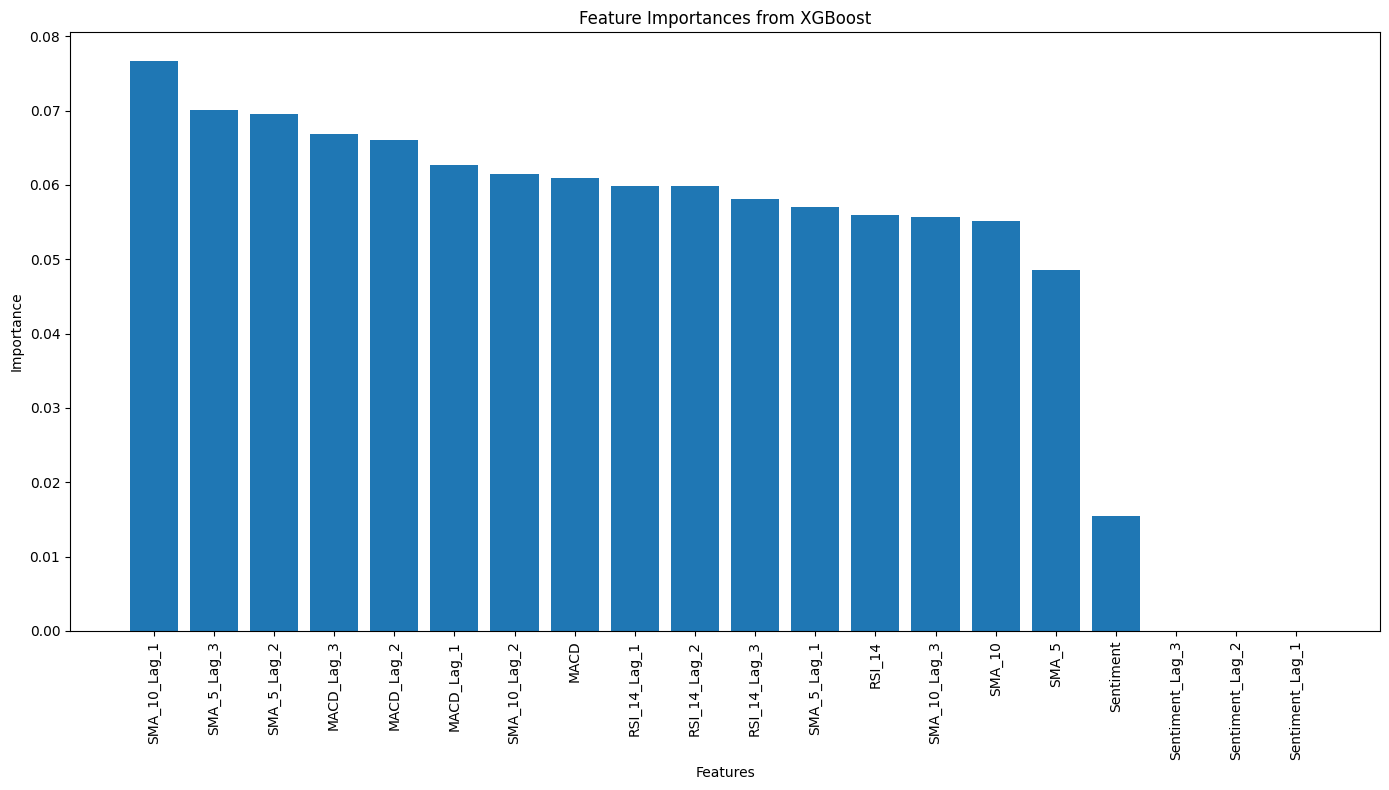

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the features used in your model
features = [
    'Sentiment', 'SMA_5', 'SMA_10', 'RSI_14', 'MACD',
    'Sentiment_Lag_1', 'SMA_5_Lag_1', 'SMA_10_Lag_1', 'RSI_14_Lag_1', 'MACD_Lag_1',
    'Sentiment_Lag_2', 'SMA_5_Lag_2', 'SMA_10_Lag_2', 'RSI_14_Lag_2', 'MACD_Lag_2',
    'Sentiment_Lag_3', 'SMA_5_Lag_3', 'SMA_10_Lag_3', 'RSI_14_Lag_3', 'MACD_Lag_3'
    # Include any other features you are using
]

# Get feature importances from the XGBoost model
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(14, 8))
plt.title("Feature Importances from XGBoost")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [39]:
# List of stock names included in your recommendations
# You might have this list or can extract it from the data
stock_names = recommendations['Stock Name'].unique()

final_portfolio_values = {}
for stock_name in stock_names:
    stock_recommendations = recommendations[recommendations['Stock Name'] == stock_name]
    stock_test_data = test_data_aligned[test_data_aligned['Stock Name'] == stock_name]
    
    # Ensure the indices align
    common_indices = stock_recommendations.index.intersection(stock_test_data.index)
    
    # Calculate portfolio value for each stock
    portfolio_value = refined_backtest_strategy(
        stock_recommendations.loc[common_indices],
        stock_test_data.loc[common_indices],
        stock_recommendations.loc[common_indices, 'Confidence']
    )
    final_portfolio_values[stock_name] = portfolio_value
    print(f"Final Portfolio Value for {stock_name}: ${portfolio_value:.2f}")

# Calculate overall portfolio performance across all stocks
total_portfolio_value = sum(final_portfolio_values.values())
print(f"Overall Portfolio Value: ${total_portfolio_value:.2f}")

Final Portfolio Value for GOOG: $10000.00
Final Portfolio Value for BA: $10000.00
Final Portfolio Value for NOC: $10000.00
Final Portfolio Value for CRM: $10000.00
Final Portfolio Value for COST: $10000.00
Final Portfolio Value for PYPL: $10000.00
Final Portfolio Value for AAPL: $10000.00
Final Portfolio Value for NIO: $10000.00
Final Portfolio Value for ZS: $10000.00
Final Portfolio Value for BX: $10000.00
Final Portfolio Value for AMD: $10000.00
Final Portfolio Value for INTC: $10000.00
Final Portfolio Value for XPEV: $10000.00
Final Portfolio Value for NFLX: $10000.00
Final Portfolio Value for TSM: $10000.00
Final Portfolio Value for MSFT: $10000.00
Final Portfolio Value for KO: $10000.00
Final Portfolio Value for PG: $10000.00
Final Portfolio Value for DIS: $10000.00
Final Portfolio Value for META: $10000.00
Final Portfolio Value for TSLA: $10000.00
Final Portfolio Value for AMZN: $10000.00
Final Portfolio Value for ENPH: $10000.00
Final Portfolio Value for VZ: $10000.00
Final Port

In [40]:
# Check the distribution of predictions
predictions_distribution = recommendations['Recommendation'].value_counts()
print("Distribution of Recommendations:")
print(predictions_distribution)

Distribution of Recommendations:
Recommendation
Sell    649
Buy     526
Name: count, dtype: int64


In [41]:
# Review confidence scores
high_confidence_buys = recommendations[recommendations['Confidence'] > 0.6]  # Example threshold
print("High Confidence Buys:")
print(high_confidence_buys)

High Confidence Buys:
           Date Stock Name Recommendation  Confidence
5    2022-03-21       PYPL            Buy    0.656206
8    2022-05-16         ZS            Buy    0.718160
10   2021-10-28         BX           Sell    0.629614
19   2021-11-01       MSFT            Buy    0.782668
21   2021-11-11         KO            Buy    0.607341
...         ...        ...            ...         ...
1136 2022-08-04       AMZN           Sell    0.602394
1143 2022-06-23       INTC            Buy    0.627944
1158 2022-05-13         ZS            Buy    0.616374
1168 2021-12-21        CRM            Buy    0.600704
1174 2022-08-09       AAPL            Buy    0.694352

[152 rows x 4 columns]


In [42]:
# Adjusted strategy logic to ensure trades are made based on confidence
def adjusted_backtest_strategy(recommendations, test_data, model_confidence, buy_threshold=0.6, sell_threshold=0.4):
    """
    Execute a trading strategy based on model recommendations and confidence scores.

    Args:
    recommendations (pd.DataFrame): DataFrame containing recommendations.
    test_data (pd.DataFrame): DataFrame containing test stock data.
    model_confidence (pd.Series): Model confidence scores for buy recommendations.
    buy_threshold (float): Confidence threshold for executing buy trades.
    sell_threshold (float): Confidence threshold for executing sell trades.

    Returns:
    float: Total return from the trading strategy.
    """
    portfolio_value = 10000  # Starting portfolio value
    position = 0  # Current position: +1 for long, 0 for no position

    # Ensure recommendations and test_data indices align
    common_indices = recommendations.index.intersection(test_data.index)

    for idx in common_indices:
        current_price = test_data.loc[idx, 'Close']
        confidence = model_confidence.loc[idx]

        # Buy if confidence is above the buy threshold
        if confidence > buy_threshold and position == 0:
            shares_to_buy = portfolio_value // current_price
            portfolio_value -= shares_to_buy * current_price
            position += shares_to_buy

        # Sell if confidence is below the sell threshold
        elif confidence < sell_threshold and position > 0:
            portfolio_value += position * current_price
            position = 0

    # Close any open positions at the end
    if position > 0:
        portfolio_value += position * test_data.loc[common_indices[-1], 'Close']

    return portfolio_value

# Run adjusted backtest for each stock
for stock_name in stock_names:
    stock_recommendations = recommendations[recommendations['Stock Name'] == stock_name]
    stock_test_data = test_data_aligned[test_data_aligned['Stock Name'] == stock_name]
    portfolio_value = adjusted_backtest_strategy(
        stock_recommendations.loc[common_indices],
        stock_test_data.loc[common_indices],
        stock_recommendations.loc[common_indices, 'Confidence']
    )
    final_portfolio_values[stock_name] = portfolio_value
    print(f"Adjusted Final Portfolio Value for {stock_name}: ${portfolio_value:.2f}")

# Calculate overall portfolio performance across all stocks
total_adjusted_portfolio_value = sum(final_portfolio_values.values())
print(f"Overall Adjusted Portfolio Value: ${total_adjusted_portfolio_value:.2f}")

Adjusted Final Portfolio Value for GOOG: $10000.00
Adjusted Final Portfolio Value for BA: $10000.00
Adjusted Final Portfolio Value for NOC: $10000.00
Adjusted Final Portfolio Value for CRM: $10000.00
Adjusted Final Portfolio Value for COST: $10000.00
Adjusted Final Portfolio Value for PYPL: $10000.00
Adjusted Final Portfolio Value for AAPL: $10000.00
Adjusted Final Portfolio Value for NIO: $10000.00
Adjusted Final Portfolio Value for ZS: $10000.00
Adjusted Final Portfolio Value for BX: $10000.00
Adjusted Final Portfolio Value for AMD: $10000.00
Adjusted Final Portfolio Value for INTC: $10000.00
Adjusted Final Portfolio Value for XPEV: $10000.00
Adjusted Final Portfolio Value for NFLX: $10000.00
Adjusted Final Portfolio Value for TSM: $10000.00
Adjusted Final Portfolio Value for MSFT: $10000.00
Adjusted Final Portfolio Value for KO: $10000.00
Adjusted Final Portfolio Value for PG: $10000.00
Adjusted Final Portfolio Value for DIS: $10000.00
Adjusted Final Portfolio Value for META: $10000

In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
from transformers import pipeline

# Initialize sentiment analysis pipeline using a pre-trained BERT model
sentiment_pipeline = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

# Function to fetch real-time stock data using yfinance
def fetch_real_time_stock_data(stock_symbol):
    stock_data = yf.Ticker(stock_symbol)
    hist = stock_data.history(period="1d", interval="1m")  # Get minute-level data for today
    return hist

# Function to fetch latest news and perform sentiment analysis
def analyze_news_sentiment(stock_symbol):
    stock = yf.Ticker(stock_symbol)
    news = stock.news  # Fetch the latest news articles
    sentiments = []

    for article in news:
        text = article.get('title', '') + ' ' + article.get('summary', '')
        sentiment = sentiment_pipeline(text)[0]['label']
        sentiment_score = {
            '1 star': -1,
            '2 stars': -0.5,
            '3 stars': 0,
            '4 stars': 0.5,
            '5 stars': 1
        }.get(sentiment, 0)
        sentiments.append(sentiment_score)

    # Return the average sentiment score
    return np.mean(sentiments) if sentiments else 0

# Function to calculate RSI
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to prepare features for the model
def prepare_features(stock_data, sentiment):
    # Calculate technical indicators like moving averages
    stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
    stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
    stock_data['RSI_14'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data['MACD'] = stock_data['Close'].ewm(span=12, adjust=False).mean() - stock_data['Close'].ewm(span=26, adjust=False).mean()

    # Add sentiment score
    stock_data['Sentiment'] = sentiment
    
    # Create lagged features
    for lag in range(1, 4):
        stock_data[f'Sentiment_Lag_{lag}'] = stock_data['Sentiment'].shift(lag)
        stock_data[f'SMA_5_Lag_{lag}'] = stock_data['SMA_5'].shift(lag)
        stock_data[f'SMA_10_Lag_{lag}'] = stock_data['SMA_10'].shift(lag)
        stock_data[f'RSI_14_Lag_{lag}'] = stock_data['RSI_14'].shift(lag)
        stock_data[f'MACD_Lag_{lag}'] = stock_data['MACD'].shift(lag)

    # Use the latest data point for prediction, filling NaNs with the most recent values available
    latest_data = stock_data.fillna(method='bfill').iloc[-1]
    features = latest_data[[
        'SMA_5', 'SMA_10', 'RSI_14', 'MACD', 'Sentiment',
        'Sentiment_Lag_1', 'SMA_5_Lag_1', 'SMA_10_Lag_1', 'RSI_14_Lag_1', 'MACD_Lag_1',
        'Sentiment_Lag_2', 'SMA_5_Lag_2', 'SMA_10_Lag_2', 'RSI_14_Lag_2', 'MACD_Lag_2',
        'Sentiment_Lag_3', 'SMA_5_Lag_3', 'SMA_10_Lag_3', 'RSI_14_Lag_3', 'MACD_Lag_3'
    ]]
    return features.values.reshape(1, -1)

# Main function to fetch data and get recommendations
def get_recommendation(stock_symbol, model):
    stock_data = fetch_real_time_stock_data(stock_symbol)
    sentiment = analyze_news_sentiment(stock_symbol)
    features = prepare_features(stock_data, sentiment)
    recommendation = model.predict(features)[0]

    # Get the latest closing price
    current_price = stock_data['Close'].iloc[-1]

    return recommendation, current_price

# Example usage with the LightGBM model
stock_symbol = 'AAPL'
recommendation, current_price = get_recommendation(stock_symbol, lgb_model)
recommendation_text = "Buy" if recommendation == 1 else "Sell"
print(f"Current price for {stock_symbol}: ${current_price:.2f}")
print(f"Recommendation for {stock_symbol}: {recommendation_text}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Current price for AAPL: $210.18
Recommendation for AAPL: Sell


C:\Users\maxpa\AppData\Local\Temp\ipykernel_5956\4183366256.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  latest_data = stock_data.fillna(method='bfill').iloc[-1]
